In [2]:
import os
import sys
import warnings
import laspy
sys.path.append("/data1/yang_liu/python_workspace/GSPL")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import random
import rawpy
import cv2
import torch
import json
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from defisheye import Defisheye
from plyfile import PlyData, PlyElement
from internal.utils.gaussian_projection import build_rotation_matrix

In [3]:
def parse_ocam_model(xml_file, cam_idx=0):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    ocam_model = root.find(f".//CameraModel[SensorName='cam{cam_idx}']/OCamModel")
    c = float(ocam_model.find('c').text)
    d = float(ocam_model.find('d').text)
    e = float(ocam_model.find('e').text)
    cx = float(ocam_model.find('cx').text)
    cy = float(ocam_model.find('cy').text)
    world2cam = [float(coeff.text) for coeff in ocam_model.findall('world2cam/coeff')]
    cam2world = [float(coeff.text) for coeff in ocam_model.findall('cam2world/coeff')]

    return c, d, e, cx, cy, world2cam, cam2world

def project_points_to_image(points, c, d, e, cx, cy, world2cam):
    # Normalize the points
    norm = np.linalg.norm(points[:, :2], axis=1)[:, None]
    theta = np.arctan2(-points[:, [2]], norm)
    
    # Apply the world2cam polynomial
    rho = 0
    theta_i = 1
    for coeff in world2cam:
        rho += coeff * theta_i
        theta_i *= theta
    
    # Compute image coordinates
    x = points[:, [0]] * rho / norm
    y = points[:, [1]] * rho / norm
    x_img = x * c + y * d + cx
    y_img = x * e + y + cy
    
    return np.concatenate([x_img, y_img, rho], axis=1)


def read_las_fit(filename, attrs=None):
    """
    读取 las 文件，获取三维坐标 xyz, 颜色 rgb, 属性 attr_dict。当文件没有 RGB 信息时，返回全0的 RGB值
    Args:
        filename: <str> las 文件路径
        attrs: <list> 需要额外获取的属性信息 如 ['label']

    Returns:
        xyz, rgb, attr_dict
    """
    if attrs is None:
        attrs = []

    # 默认返回 scales, offsets ，合并 ["scales", "offsets"]
    attrs = list(set(attrs + ["scales", "offsets"]))

    # 读取点云
    inFile = laspy.read(filename)
    # inFile.point_format.dimensions可以获取所有的维度信息
    N_points = len(inFile)
    x = np.reshape(inFile.x, (N_points, 1))
    y = np.reshape(inFile.y, (N_points, 1))
    z = np.reshape(inFile.z, (N_points, 1))
    xyz = np.hstack((x, y, z))
    # TODO 注意。如果是大写的 X Y Z，需要转换后才是真实坐标: real_x = scale[0] * inFile.X + offset[0]

    # 初始化 rgb 全是 0
    rgb = np.zeros((N_points, 3), dtype=np.uint16)
    if hasattr(inFile, "red") and hasattr(inFile, "green") and hasattr(inFile, "blue"):
        r = np.reshape(inFile.red, (N_points, 1))
        g = np.reshape(inFile.green, (N_points, 1))
        b = np.reshape(inFile.blue, (N_points, 1))
        # i = np.reshape(inFile.Reflectance, (N_points, 1))
        rgb = np.float32(np.hstack((r, g, b))) / 65535
    else:
        print(f"注意：{filename.split('/')[-1]} 没有RGB信息，返回全0的RGB信息！")

    # 组织其他属性信息
    attr_dict = {}
    for attr in attrs:
        value = None
        # 先判断 是否为额外属性
        if hasattr(inFile, attr):
            value = getattr(inFile, attr)
        # 再判断 header 中是否有该属性
        elif hasattr(inFile.header, attr):
            value = getattr(inFile.header, attr)
        else:
            warnings.warn(f"{filename.split('/')[-1]} 没有属性= {attr} 的信息！", category=Warning)  # 使用 warnning 警告

        if hasattr(value, "array"):
            attr_dict[attr] = np.array(value)
        else:
            attr_dict[attr] = value

    return xyz, rgb, attr_dict

## 1. Read Data

In [12]:
dir_path = "../data/GKD/ground/input/2024-08-13_05.18.43"

In [28]:
ds_interval = 50

# Load PCD under VLX coordinate
# pcd_path = os.path.join(dir_path, dir_path.split('/')[-1] + '.ply')
# plydata = PlyData.read(pcd_path)
# data = plydata.elements[0].data[::ds_interval]
# property_names = data[0].dtype.names
# data = pd.DataFrame(data)
# data_np = np.zeros(data.shape, dtype=float)
# for i, name in enumerate(property_names):
#     data_np[:, i] = data[name]

# Load PCD under CGCS2000 coordinate
alignment = json.load(open(os.path.join('../data/GKD/ground/align', dir_path.split('/')[-1], 'alignment.json')))
xyz_ground, rgb_ground, _ = read_las_fit(os.path.join('../data/GKD/ground/pcd', dir_path.split('/')[-1] + '.las'), ["scales", "offsets"])
xyz_ground = xyz_ground[::ds_interval]
rgb_ground = rgb_ground[::ds_interval]

transform = np.array([
    [alignment['transform']['r11'], alignment['transform']['r12'], alignment['transform']['r13'], alignment['transform']['tx']],
    [alignment['transform']['r21'], alignment['transform']['r22'], alignment['transform']['r23'], alignment['transform']['ty']],
    [alignment['transform']['r31'], alignment['transform']['r32'], alignment['transform']['r33'], alignment['transform']['tz']],
    [0, 0, 0, 1]
])

src_pcd_homo = np.concatenate((xyz_ground, np.ones_like(xyz_ground[:, :1])), axis=-1)
if alignment['parent'] is not None:
    transform_parent = np.array([
        [alignment['parent']['transform']['r11'], alignment['parent']['transform']['r12'], alignment['parent']['transform']['r13'], alignment['parent']['transform']['tx']],
        [alignment['parent']['transform']['r21'], alignment['parent']['transform']['r22'], alignment['parent']['transform']['r23'], alignment['parent']['transform']['ty']],
        [alignment['parent']['transform']['r31'], alignment['parent']['transform']['r32'], alignment['parent']['transform']['r33'], alignment['parent']['transform']['tz']],
        [0, 0, 0, 1]
    ]) 
else:
    transform_parent = np.eye(4)

dst_pcd = np.dot(src_pcd_homo, np.linalg.inv(transform_parent).T)
dst_pcd = np.dot(dst_pcd, np.linalg.inv(transform).T)
data_np = np.concatenate((dst_pcd[:, :3], rgb_ground), axis=-1)

In [30]:
image_idx = 0
cam_idx = 3

# Load info
info_path = os.path.join(dir_path, 'info', f"{image_idx:05d}-info.json")
with open(info_path, "r") as f:
    info = json.loads(f.read())

intrinsics_path = os.path.join(dir_path, "sensor_frame.xml")
c, d, e, cx, cy, world2cam, cam2world = parse_ocam_model(intrinsics_path, cam_idx)      

cam = info[f"cam{cam_idx}"]
cam_p = cam['position']
cam_q = cam['quaternion']

(-36.56213464016274,
 109.88980288371553,
 -44.638318438917956,
 62.969276991823236)

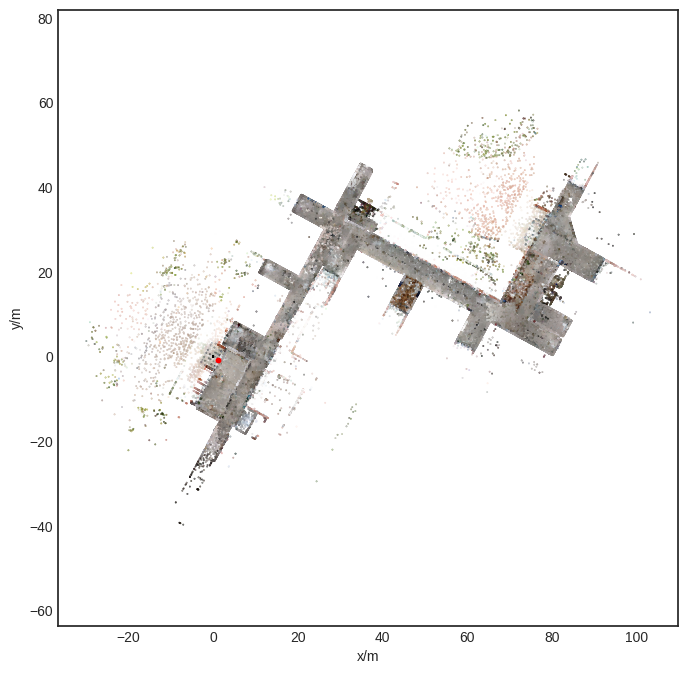

In [31]:
xyz = data_np[:, :3]
if data_np[:, 3:6].max() > 1.0:
    rgb = data_np[:, 3:6] / 255.0
else:
    rgb = data_np[:, 3:6]

plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz[::50, 0], xyz[::50, 1], c=rgb[::50], s=0.1)
plt.scatter(cam_p[0], cam_p[1], c='r', s=10)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

In [16]:
rgb_img_path = os.path.join(dir_path, "cam", f"{image_idx:05d}-cam{cam_idx}.dng")
with rawpy.imread(rgb_img_path) as raw:
    img = raw.postprocess(use_camera_wb=True, use_auto_wb=False, exp_shift=3)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [32]:
c2w = np.eye(4)
c2w[:3, :3] = np.array(build_rotation_matrix(torch.tensor(cam_q)[None, :]))[0]
c2w[:3, 3] = np.array(cam_p)

if cam_idx == 0:
    c2w[:, 0] *= -1  # cam 0
else:
    c2w[:, 1] *= -1  # cam 1, 2, 3
c2w = c2w[:, [1, 0, 2, 3]]

print("c2w: \n", c2w)

w2c = np.linalg.inv(c2w)
print("Extrinsics: \n", w2c)

c2w: 
 [[ 0.48336592 -0.13568604 -0.86483914  1.09801604]
 [ 0.87541664  0.07693294  0.47720763 -0.91705882]
 [ 0.00178427 -0.98776048  0.15596849  0.99811595]
 [-0.          0.          0.          1.        ]]
Extrinsics: 
 [[ 0.48336589  0.87541656  0.0017842   0.27028413]
 [-0.13568593  0.07693294 -0.98776035  1.20543671]
 [-0.86483912  0.4772076   0.15596856  1.23155996]
 [ 0.          0.          0.          1.        ]]


w2c_: 
 [[-9.99925008e-01  1.21146681e-02  1.78420084e-03  4.18112209e+05]
 [-3.65181042e-03 -1.55935929e-01 -9.87760345e-01  6.99600189e+05]
 [-1.16881482e-02 -9.87692882e-01  1.55968556e-01  4.42529533e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
c2w_: 
 [[-9.99925037e-01 -3.65175004e-03 -1.16881686e-02  4.72359229e+05]
 [ 1.21146578e-02 -1.55936017e-01 -9.87692860e-01  4.47486018e+06]
 [ 1.78426504e-03 -9.87760484e-01  1.55968487e-01  8.47795708e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(472266.64417840744, 472403.5407184074, 4474823.579966591, 4474950.610276592)

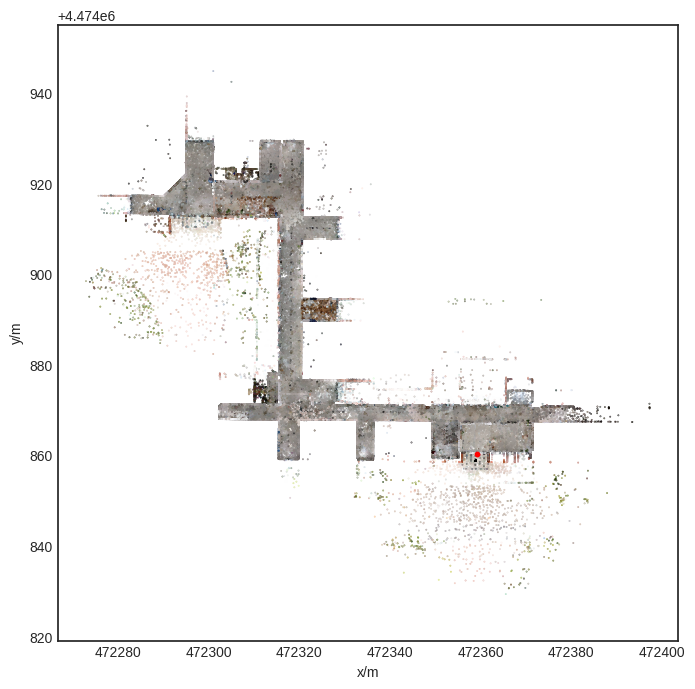

In [45]:
w2c_ = np.dot(w2c, np.dot(np.linalg.inv(transform), np.linalg.inv(transform_parent)))
c2w_ = np.linalg.inv(w2c_)
print("w2c_: \n", w2c_)
print("c2w_: \n", c2w_)

xyz_cam = np.dot(src_pcd_homo, w2c_.T)

plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz_ground[::50, 0], xyz_ground[::50, 1], c=rgb_ground[::50], s=0.1)
plt.scatter(c2w_[0, 3], c2w_[1, 3], c='r', s=10)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

## 2. Point to Fisheye Projection

In [41]:
# Project 3D points to 2D
# xyz_h = np.concatenate([xyz, np.ones((xyz.shape[0], 1))], axis=-1)
# xyz_cam = np.dot(xyz_h, w2c.T)
xyz_cam = xyz_cam[:, :3]
xyz_proj = xyz_cam / xyz_cam[:, [2]]

xyz_proj = project_points_to_image(xyz_cam, c, d, e, cx, cy, world2cam)
rgb_proj = rgb

# Filter out points outside the image
H, W = img.shape[:2]
valid_pos = np.where((xyz_cam[:, 2] > 0) & np.all(xyz_proj >= 0, axis=-1) & (xyz_proj[:, 0] < W) & (xyz_proj[:, 1] < H))
xyz_proj = xyz_proj[valid_pos]
rgb_proj = rgb[valid_pos]
# sort xyz_proj by z
sort_idx = np.argsort(-np.linalg.norm(xyz_cam[valid_pos], axis=-1))
xyz_proj = xyz_proj[sort_idx]
rgb_proj = rgb_proj[sort_idx]

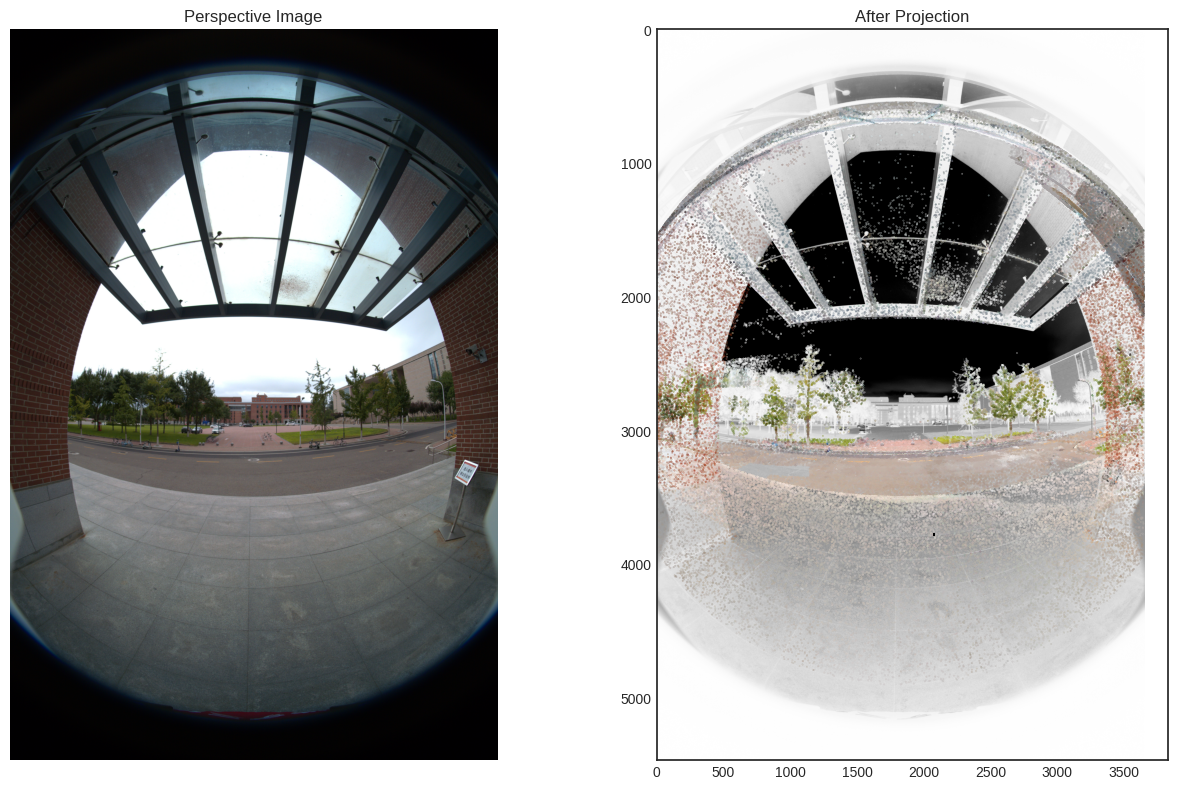

In [42]:
vis_interval = 1
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(img)
plt.title("Perspective Image")
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
plt.imshow(gray_img)
plt.scatter(xyz_proj[::vis_interval, 0], xyz_proj[::vis_interval, 1], c=rgb_proj[::vis_interval], s=0.1, alpha=0.5)  # vis Image Points
# plt.scatter(xyz_cam[::vis_interval, 2], -xyz_cam[::vis_interval, 0], c=rgb[::vis_interval], s=0.1)  # vis BEV Points
# plt.scatter(xyz_cam[::vis_interval, 0], -xyz_cam[::vis_interval, 1], c=rgb[::vis_interval], s=0.1)  # vis Perspective Points
plt.title("After Projection")
# plt.axis("off")
plt.tight_layout()

## 3. Perspective Projection

In [ ]:
from numpy import ndarray, hypot, arctan, pi, sin, cos, tan, sqrt, arange, meshgrid

class DeNavfisheye(Defisheye):
    def __init__(self, infile, **kwargs):
        vkwargs = {"fov": 180,
                   "pfov": 120,
                   "xcenter": None,
                   "ycenter": None,
                   "radius": None,
                   "pad": 0,
                   "c": 0,
                   "d": 0,
                   "e": 0,
                   "cam2world": list,
                   "world2cam": list,
                   "format": "fullframe"
                   }
        self._start_att(vkwargs, kwargs)

        if type(infile) == str:
            _image = cv2.imread(infile)
        elif type(infile) == ndarray:
            _image = infile
        else:
            raise Exception("Image format not recognized")

        if self._pad > 0:
            _image = cv2.copyMakeBorder(
                _image, self._pad, self._pad, self._pad, self._pad, cv2.BORDER_CONSTANT)

        width = _image.shape[1]
        height = _image.shape[0]
        xcenter = width // 2
        ycenter = height // 2

        dim = min(width, height)
        x0 = xcenter - dim // 2
        xf = xcenter + dim // 2
        y0 = ycenter - dim // 2
        yf = ycenter + dim // 2

        self._image = _image

        self._width = _image[y0:yf, x0:xf, :].shape[1]
        self._height = _image[y0:yf, x0:xf, :].shape[0]

        if self._xcenter is None:
            self._xcenter = (self._width - 1) // 2

        if self._ycenter is None:
            self._ycenter = (self._height - 1) // 2
    
    def _map(self, i, j, ofoc, angle):

        xd = i - (self._width - 1) // 2
        yd = j - (self._height - 1) // 2

        angle_ = angle * np.pi / 180
        coords = np.stack([xd, yd, ofoc * np.ones_like(xd)], axis=-1)
        rot_mat = np.array([[cos(angle_), 0, sin(angle_)], [0, 1, 0], [-sin(angle_), 0, cos(angle_)]])
        coords = np.dot(coords, rot_mat)
        xd, yd, zd = coords[..., 0], coords[..., 1], coords[..., 2]

        rd = hypot(xd, yd)
        phiang = arctan(-zd / rd)
        
        # Apply the world2cam polynomial
        rho = 0
        theta_i = 1
        for coeff in self._world2cam:
            rho += coeff * theta_i
            theta_i *= phiang

        rdmask = rd != 0
        xs = xd.copy()
        ys = yd.copy()

        x = (rho[rdmask] / rd[rdmask]) * xd[rdmask]
        y = (rho[rdmask] / rd[rdmask]) * yd[rdmask]
        xs[rdmask] = x * self._c + y * self._d + self._xcenter
        ys[rdmask] = x * self._e + y + self._ycenter

        rdmask[rdmask] = (xs[rdmask] >= 0) & (xs[rdmask] < self._image.shape[1]) & \
                         (ys[rdmask] >= 0) & (ys[rdmask] < self._image.shape[0]) 

        xs[~rdmask] = 0
        ys[~rdmask] = 0

        xs = xs.astype(int)
        ys = ys.astype(int)
        return xs, ys
    
    def convert(self, outfile=None, angle=0.0):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius

        # compute output (perspective) focal length and its inverse from ofov
        # phi=fov/2; r=N/2
        # r/f=tan(phi);
        # f=r/tan(phi);
        # f= (N/2)/tan((fov/2)*(pi/180)) = N/(2*tan(fov*pi/360))

        ofoc = dim / (2 * tan(self._pfov * pi / 360))

        i = arange(self._width)
        j = arange(self._height)
        i, j = meshgrid(i, j)

        xs, ys, = self._map(i, j, ofoc, angle)
        img = np.zeros((self._height, self._width, 3), dtype=self._image.dtype)

        img[j, i, :] = self._image[ys, xs, :]
        if outfile is not None:
            cv2.imwrite(outfile, img)
        return img, ofoc

In [ ]:
format = 'circular'
pfov = 90

obj = DeNavfisheye(img, format=format, pfov=pfov, c=c, d=d, e=e, xcenter=cx, ycenter=cy, cam2world=cam2world, world2cam=world2cam)
new_image, f_p = obj.convert()

H, W = new_image.shape[:2]
cx_p = (W - 1) // 2
cy_p = (H - 1) // 2
K = np.array([[f_p, 0, cx_p], [0, f_p, cy_p], [0, 0, 1]])
print("Intrinsics: \n", K)

xyz_h = np.concatenate([xyz, np.ones((xyz.shape[0], 1))], axis=-1)
xyz_cam = np.dot(xyz_h, w2c.T)
xyz_cam = xyz_cam[:, :3]
xyz_proj = xyz_cam / xyz_cam[:, [2]]
xyz_proj = np.dot(xyz_proj, K.T)

# Filter out points outside the image
valid_pos = np.where((xyz_cam[:, 2] > 0) & np.all(xyz_proj >= 0, axis=-1) & (xyz_proj[:, 0] < W) & (xyz_proj[:, 1] < H))
xyz_proj = xyz_proj[valid_pos]
rgb_proj = rgb[valid_pos]
sort_idx = np.argsort(-xyz_cam[valid_pos][:, 2])
xyz_proj = xyz_proj[sort_idx]
rgb_proj = rgb_proj[sort_idx]

/tmp/ipykernel_36037/1555044262.py:65: RuntimeWarning: divide by zero encountered in divide
  phiang = arctan(-zd / rd)


Intrinsics: 
 [[1.824e+03 0.000e+00 1.823e+03]
 [0.000e+00 1.824e+03 1.823e+03]
 [0.000e+00 0.000e+00 1.000e+00]]


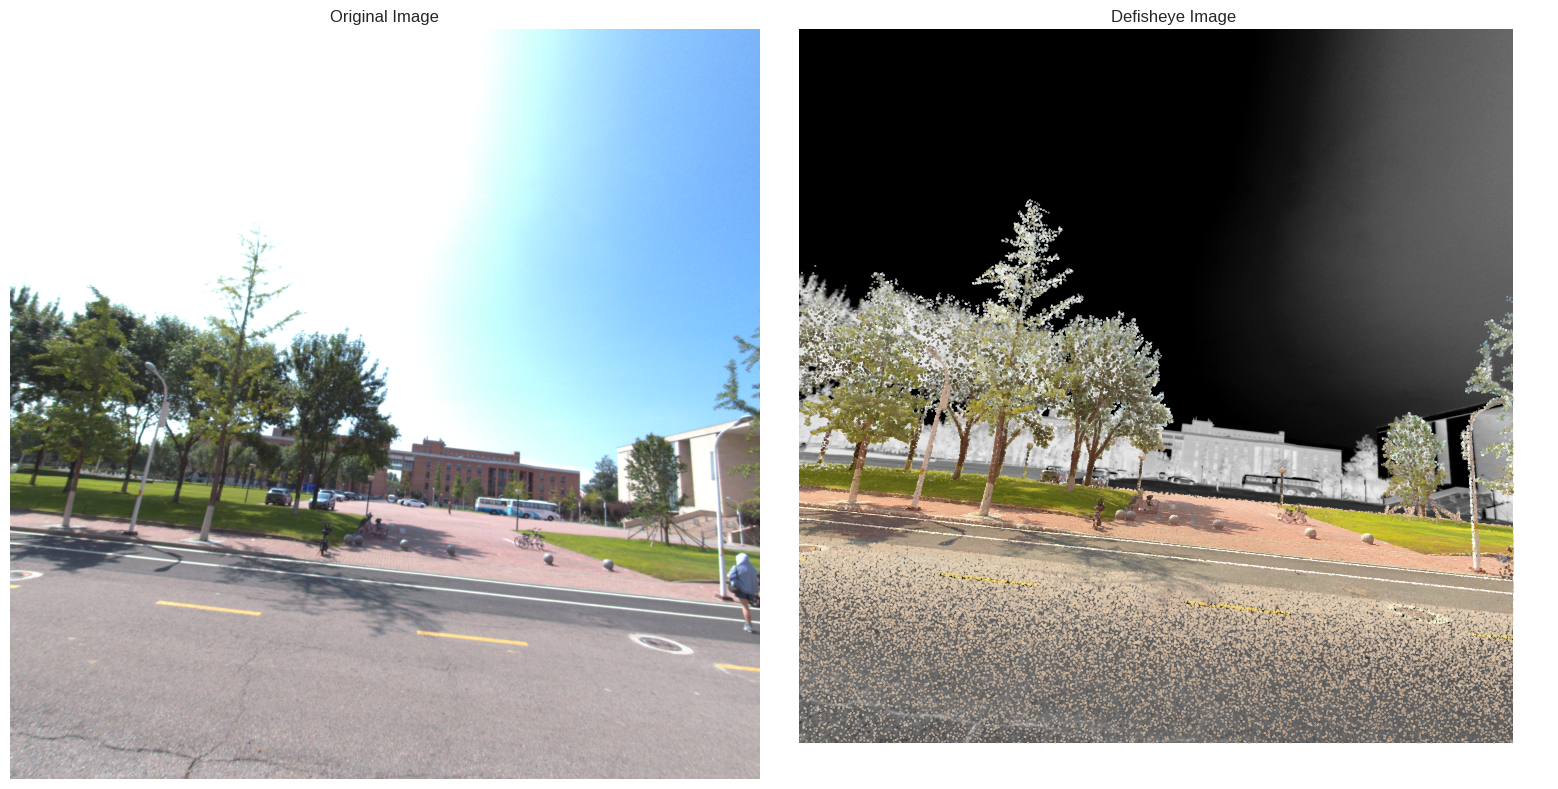

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(new_image)
plt.title("Original Image")
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY))
plt.title("Defisheye Image")
vis_interval = 1
plt.scatter(xyz_proj[::vis_interval, 0], xyz_proj[::vis_interval, 1], c=rgb_proj[::vis_interval], s=0.1)
plt.axis("off")
plt.tight_layout()

## 4. Query Perspective images from all fisheyes

In [ ]:
from numpy import ndarray, hypot, arctan, pi, sin, cos, tan, sqrt, arange, meshgrid

class DeNavfisheyeX(DeNavfisheye):
    def get_coords(self, angle=0.0):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius


        ofoc = dim / (2 * tan(self._pfov * pi / 360))

        i = arange(self._width)
        j = arange(self._height)
        i, j = meshgrid(i, j)

        xd = i - (self._width - 1) // 2
        yd = j - (self._height - 1) // 2

        angle_ = angle * np.pi / 180
        coords = np.stack([xd, yd, ofoc * np.ones_like(xd)], axis=-1)
        rot_mat = np.array([[cos(angle_), 0, sin(angle_)], [0, 1, 0], [-sin(angle_), 0, cos(angle_)]])
        coords = np.dot(coords, rot_mat)
        xd, yd, zd = coords[..., 0], coords[..., 1], coords[..., 2]

        rd = hypot(xd, yd)
        phiang = arctan(-zd / rd)
        
        # Apply the world2cam polynomial
        rho = 0
        theta_i = 1
        for coeff in self._world2cam:
            rho += coeff * theta_i
            theta_i *= phiang

        rdmask = rd != 0

        xyz = np.zeros((self._height, self._width, 3), dtype=float)

        xyz[rdmask, 0] = (rho[rdmask] / rd[rdmask]) * xd[rdmask]
        xyz[rdmask, 1] = (rho[rdmask] / rd[rdmask]) * yd[rdmask]
        
        r_i = 1
        for coeff in self._cam2world:
            xyz[..., 2] += coeff * r_i
            r_i *= rho
        xyz[..., 2] *= -1

        return xyz
    
    def residual_convert(self, xyz, outfile=None):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius

        # compute output (perspective) focal length and its inverse from ofov
        # phi=fov/2; r=N/2
        # r/f=tan(phi);
        # f=r/tan(phi);
        # f= (N/2)/tan((fov/2)*(pi/180)) = N/(2*tan(fov*pi/360))

        ofoc = dim / (2 * tan(self._pfov * pi / 360))

        i = arange(self._width)
        j = arange(self._height)
        i, j = meshgrid(i, j)

        xs, ys, = self._residual_map(xyz)
        img = np.zeros((self._height, self._width, 3), dtype=self._image.dtype)

        img[j, i, :] = self._image[ys, xs, :]
        if outfile is not None:
            cv2.imwrite(outfile, img)
        return img, ofoc
    
    def _residual_map(self, xyz):

        xd, yd, zd = xyz[..., 0], xyz[..., 1], xyz[..., 2]

        rd = hypot(xd, yd)
        phiang = arctan(-zd / rd)
        
        # Apply the world2cam polynomial
        rho = 0
        theta_i = 1
        for coeff in self._world2cam:
            rho += coeff * theta_i
            theta_i *= phiang

        rdmask = rd != 0
        xs = xd.copy()
        ys = yd.copy()

        x = (rho[rdmask] / rd[rdmask]) * xd[rdmask]
        y = (rho[rdmask] / rd[rdmask]) * yd[rdmask]
        xs[rdmask] = x * self._c + y * self._d + self._xcenter
        ys[rdmask] = x * self._e + y + self._ycenter

        rdmask[rdmask] = (xs[rdmask] >= 0) & (xs[rdmask] < self._image.shape[1]) & \
                         (ys[rdmask] >= 0) & (ys[rdmask] < self._image.shape[0]) 

        xs[~rdmask] = 0
        ys[~rdmask] = 0

        xs = xs.astype(int)
        ys = ys.astype(int)
        return xs, ys

In [ ]:
format = 'circular'
pfov = 135
angle = 0
image_idx = 50

In [ ]:
c, d, e, cx, cy, world2cam, cam2world = parse_ocam_model(intrinsics_path, 0)
rgb_img_path = os.path.join(dir_path, "cam", f"{image_idx:05d}-cam{0}.jpg")
img = cv2.imread(rgb_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
obj0 = DeNavfisheyeX(img, format=format, pfov=pfov, c=c, d=d, e=e, xcenter=cx, ycenter=cy, cam2world=cam2world, world2cam=world2cam)
image0, f_0 = obj0.convert(angle=angle)
xyz = obj0.get_coords(angle=angle)

/tmp/ipykernel_16556/1555044262.py:65: RuntimeWarning: divide by zero encountered in divide
  phiang = arctan(-zd / rd)
/tmp/ipykernel_16556/554837367.py:30: RuntimeWarning: divide by zero encountered in divide
  phiang = arctan(-zd / rd)


In [ ]:
c, d, e, cx, cy, world2cam, cam2world = parse_ocam_model(intrinsics_path, 1)
rgb_img_path = os.path.join(dir_path, "cam", f"{image_idx:05d}-cam{1}.jpg")
img = cv2.imread(rgb_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
obj1 = DeNavfisheyeX(img, format=format, pfov=pfov, c=c, d=d, e=e, xcenter=cx, ycenter=cy, cam2world=cam2world, world2cam=world2cam)
xyz_norm = xyz / np.linalg.norm(xyz, axis=-1)[:, :, None]

In [ ]:
cam_0 = info[f"cam{0}"]
cam_1 = info[f"cam{1}"]

# Camera 0
cam_p_0 = cam_0['position']
cam_q_0 = cam_0['quaternion']
c2w_0 = np.eye(4)
c2w_0[:3, :3] = np.array(build_rotation_matrix(torch.tensor(cam_q_0)[None, :]))[0]
c2w_0[:3, 3] = np.array(cam_p_0)

c2w_0[:, 0] *= -1
c2w_0 = c2w_0[:, [1, 0, 2, 3]]
print("c2w_0: \n", c2w_0)

# Camera 1
cam_p_1 = cam_1['position']
cam_q_1 = cam_1['quaternion']
c2w_1 = np.eye(4)
c2w_1[:3, :3] = np.array(build_rotation_matrix(torch.tensor(cam_q_1)[None, :]))[0]
c2w_1[:3, 3] = np.array(cam_p_1)

c2w_1[:, 1] *= -1
c2w_1 = c2w_1[:, [1, 0, 2, 3]]
print("c2w_1: \n", c2w_1)
w2c_1 = np.linalg.inv(c2w_1)

c2w_0: 
 [[ -0.9896102   -0.12208927   0.07593372 -39.02000213]
 [ -0.04391003  -0.24626103  -0.96820837  19.90785452]
 [  0.1369074   -0.96148312   0.23834145   0.42314775]
 [  0.          -0.           0.           1.        ]]
c2w_1: 
 [[-5.61584011e-02 -3.88089180e-01 -9.19909239e-01 -3.91365552e+01]
 [ 9.98293400e-01 -7.04305060e-03 -5.79722673e-02  2.00133549e+01]
 [ 1.60194468e-02 -9.21594858e-01  3.87822390e-01  4.40051595e-01]
 [-0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
xyz_homo = np.concatenate([xyz_norm, np.ones([xyz_norm.shape[0], xyz_norm.shape[1], 1])], axis=-1)
xyz_w = np.dot(xyz_homo, c2w_0.T)
xyz_1 = np.dot(xyz_w, w2c_1.T)
image1, f_1 = obj1.residual_convert(xyz_1)

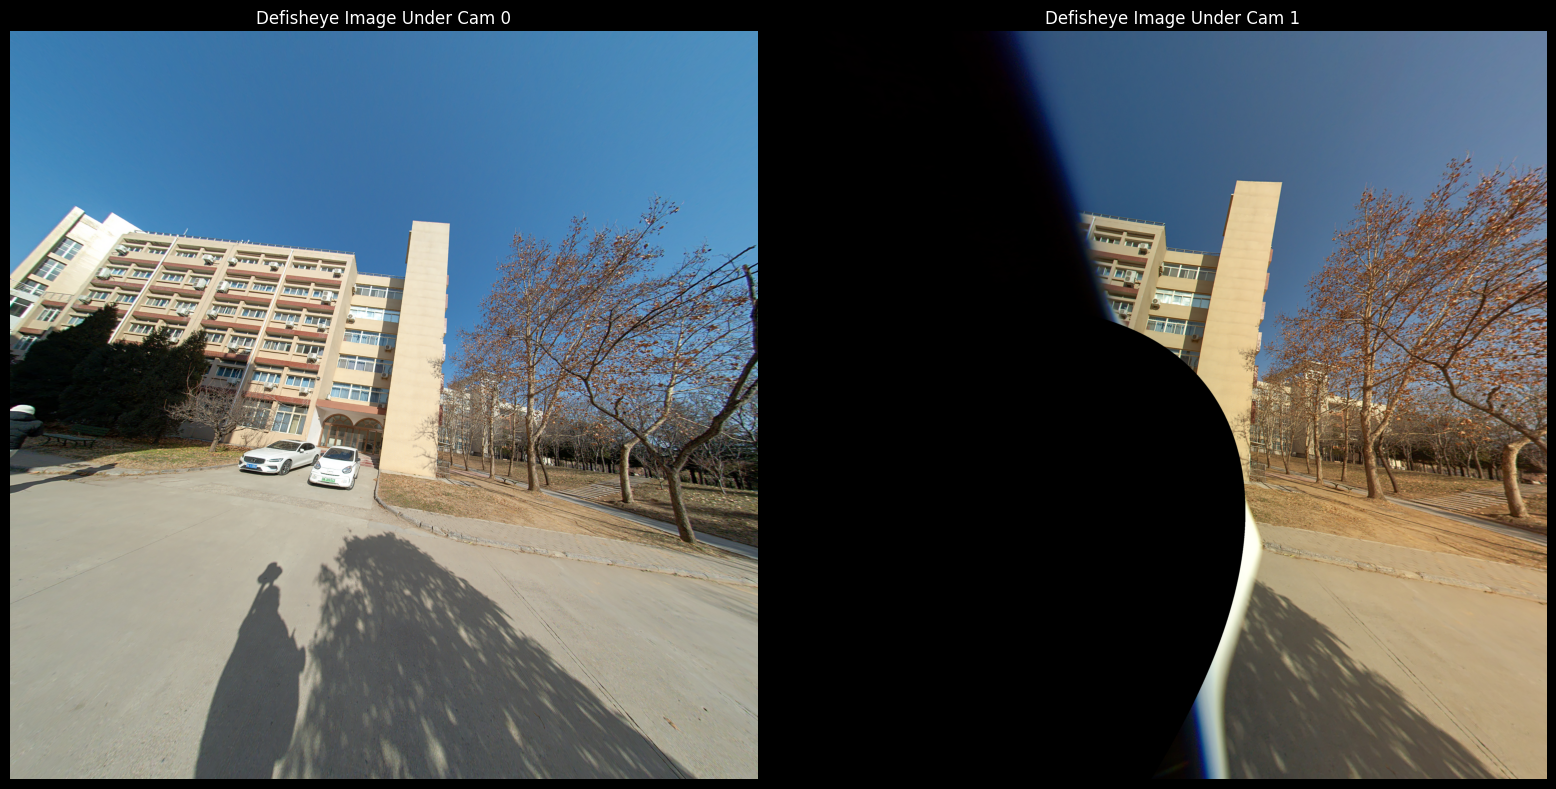

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(image0)
plt.title("Defisheye Image Under Cam 0")
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
plt.imshow(image1)
plt.title("Defisheye Image Under Cam 1")
plt.axis("off")
plt.tight_layout()

## 5. Process Aerial View Data

In [ ]:
aerial_dir_path = "../data/GKD/aerial"
aerial_xml_file = "../data/GKD/aerial/info.xml"
tree = ET.parse(aerial_xml_file)
root = tree.getroot()

num_images = len(root.findall(".//Photogroup/Photo"))

f = float(root.find(f".//Photogroup/FocalLengthPixels").text)
cx = float(root.find(f".//Photogroup/PrincipalPoint/x").text)
cy = float(root.find(f".//Photogroup/PrincipalPoint/y").text)
width = int(root.find(f".//Photogroup/ImageDimensions/Width").text)
height = int(root.find(f".//Photogroup/ImageDimensions/Height").text)

K1 = float(root.find(f".//Photogroup/Distortion/K1").text)
K2 = float(root.find(f".//Photogroup/Distortion/K2").text)
K3 = float(root.find(f".//Photogroup/Distortion/K3").text)
P1 = float(root.find(f".//Photogroup/Distortion/P1").text)
P2 = float(root.find(f".//Photogroup/Distortion/P2").text)

print(f"K1: {K1}, K2: {K2}, K3: {K3}, P1: {P1}, P2: {P2}")

K1: 0.0716509497008201, K2: -0.0998114450688689, K3: 0.0511974123088771, P1: -0.000919960018567255, P2: 8.70382886783346e-05


In [ ]:
aerial_pcd_path = os.path.join(aerial_dir_path, 'pcd')
aerial_pcd_list = sorted([os.path.join(aerial_pcd_path, f) for f in os.listdir(aerial_pcd_path) if f.endswith('.las')])
xyz_aerial_list, rgb_aerial_list = [], []
for aerial_pcd_file in aerial_pcd_list:
    xyz_aerial, rgb_aerial, _ = read_las_fit(aerial_pcd_file, ["scales", "offsets"])
    xyz_aerial_list.append(xyz_aerial[::500])
    rgb_aerial_list.append(rgb_aerial[::500])

xyz_aerial = np.concatenate(xyz_aerial_list, axis=0)
rgb_aerial = np.concatenate(rgb_aerial_list, axis=0)

(472182.0570609454, 472544.4961303686, 4474805.243957579, 4475013.941713011)

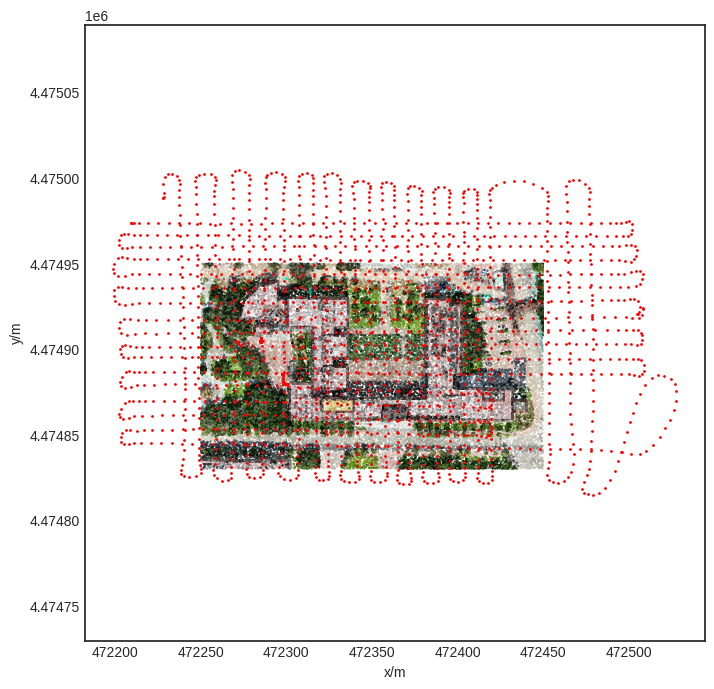

In [ ]:
aerial_centers = []

for aerial_cid in range(num_images):
    X = float(root.find(f".//Photogroup/Photo[Id='{aerial_cid}']/Pose/Center/x").text)
    Y = float(root.find(f".//Photogroup/Photo[Id='{aerial_cid}']/Pose/Center/y").text)
    Z = float(root.find(f".//Photogroup/Photo[Id='{aerial_cid}']/Pose/Center/z").text)
    aerial_centers.append([X, Y, Z])

aerial_centers = np.array(aerial_centers)

plt.style.use('seaborn-v0_8-white')
plt.figure(figsize=(8, 8))
plt.scatter(xyz_aerial[::10, 0], xyz_aerial[::10, 1], c=rgb_aerial[::10], s=0.1)
plt.scatter(aerial_centers[:, 0], aerial_centers[:, 1], c='r', s=1.0)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.axis('equal')

In [ ]:
# aerial_cam_id = random.randint(0, num_images)
aerial_cam_id = 864

M_00 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_00").text)
M_01 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_01").text)
M_02 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_02").text)
M_10 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_10").text)
M_11 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_11").text)
M_12 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_12").text)
M_20 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_20").text)
M_21 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_21").text)
M_22 = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Rotation/M_22").text)

X = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Center/x").text)
Y = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Center/y").text)
Z = float(root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/Pose/Center/z").text)

xml_image_path = root.find(f".//Photogroup/Photo[Id='{aerial_cam_id}']/ImagePath").text
aerial_image_path = os.path.join(aerial_dir_path, xml_image_path.split('/')[-2], xml_image_path.split('/')[-1])
aerial_image = cv2.imread(aerial_image_path)
aerial_image = cv2.cvtColor(aerial_image, cv2.COLOR_BGR2RGB)
H, W = aerial_image.shape[:2]

c2w = np.array([[M_00, M_10, M_20, X], 
                [M_01, M_11, M_21, Y], 
                [M_02, M_12, M_22, Z], 
                [0, 0, 0, 1]])
print("c2w matrix: \n", c2w)
w2c = np.linalg.inv(c2w)
print("w2c matrix: \n", w2c)
intrinsics = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]])
print("Intrinsics: \n", intrinsics)

new_intrinsics, roi = cv2.getOptimalNewCameraMatrix(intrinsics, np.array([K1, K2, P1, P2, K3]), (W, H), 1, (W, H))
undistorted_image = cv2.undistort(aerial_image, intrinsics, np.array([K1, K2, P1, P2, K3]), newCameraMatrix=new_intrinsics)
x, y, w, h = roi
undistorted_image = undistorted_image[y:y+h, x:x+w]
new_intrinsics[0, 2] -= x
new_intrinsics[1, 2] -= y

aerial_ds_interval = 1
projected_aerial = np.dot(np.concatenate([xyz_aerial[::aerial_ds_interval], np.ones((xyz_aerial[::aerial_ds_interval].shape[0], 1))], axis=-1), w2c.T)
mask = projected_aerial[:, 2] > 0
projected_aerial = projected_aerial[mask, :3]
projected_aerial_color = rgb_aerial[::aerial_ds_interval][mask]

cam_aerial = projected_aerial / projected_aerial[:, [2]]
cam_aerial = np.dot(cam_aerial, new_intrinsics.T)

# Filter out points outside the image
valid_pos = np.where(np.all(cam_aerial >= 0, axis=-1) & (cam_aerial[:, 0] < w) & (cam_aerial[:, 1] < h))
xyz_proj = cam_aerial[valid_pos]
rgb_proj = projected_aerial_color[valid_pos]
sort_idx = np.argsort(-projected_aerial[valid_pos][:, 2])
xyz_proj = xyz_proj[sort_idx]
rgb_proj = rgb_proj[sort_idx]

c2w matrix: 
 [[-1.75300790e-01  3.83671663e-01 -9.06678382e-01  4.72503226e+05]
 [ 9.84514573e-01  6.75400383e-02 -1.61769583e-01  4.47488465e+06]
 [-8.29312357e-04 -9.20996416e-01 -3.89570166e-01  1.31180618e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
w2c matrix: 
 [[-1.75300790e-01  9.84514573e-01 -8.29312357e-04 -4.32275885e+06]
 [ 3.83671663e-01  6.75400383e-02 -9.20996416e-01 -4.83399162e+05]
 [-9.06678382e-01 -1.61769583e-01 -3.89570166e-01  1.15235979e+06]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Intrinsics: 
 [[2.84676940e+03 0.00000000e+00 1.90768112e+03]
 [0.00000000e+00 2.84676940e+03 1.06659869e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


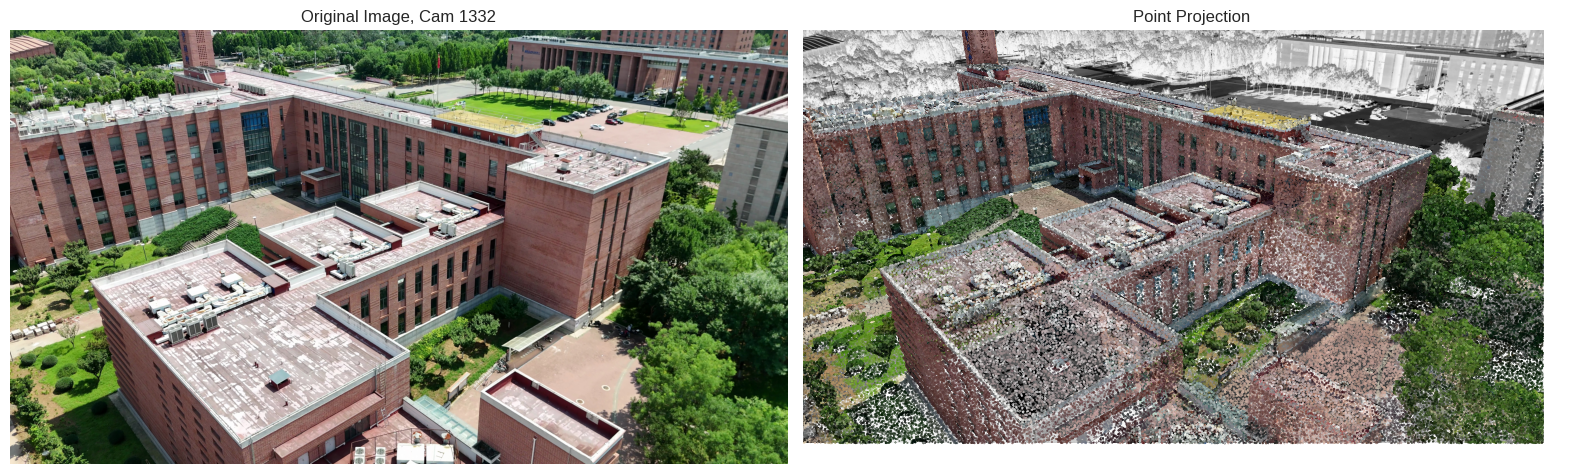

In [ ]:
vis_interval = 1
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(undistorted_image)
plt.title("Original Image, Cam %d" % aerial_cam_id)
plt.axis("off")
plt.tight_layout()

plt.subplot(122)
# plt.title("Undistorted")
# plt.imshow(undistorted_image)

plt.title("Point Projection")
plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY))
# plt.scatter(projected_aerial[:, 0], -projected_aerial[:, 1], c=projected_aerial_color, s=0.1)
plt.scatter(xyz_proj[:, 0], xyz_proj[:, 1], c=rgb_proj, s=0.1)

plt.axis("off")
plt.tight_layout()